In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM
import math
from sklearn.preprocessing import MinMaxScaler

from yahoo_fin.stock_info import get_data

In [2]:
IBM_df= get_data("IBM", start_date="12/04/2010", end_date="07/04/2022", index_as_date = False, interval="1d")
IBM_df

,date,open,high,low,close,adjclose,volume,ticker
0,2010-12-06,138.183563,139.455063,138.164429,138.613770,91.798065,3474603,IBM
1,2010-12-07,139.598465,139.866150,137.543015,137.686417,91.183945,5050716,IBM
2,2010-12-08,138.001907,139.244736,137.514343,138.604202,91.791710,5189624,IBM
3,2010-12-09,139.521988,139.521988,137.208420,137.954117,91.361206,4607944,IBM
4,2010-12-10,138.508606,138.575531,137.409180,138.451248,91.690460,3664975,IBM
...,...,...,...,...,...,...,...,...
2908,2022-06-27,142.259995,143.830002,141.949997,142.800003,141.023209,3936000,IBM
2909,2022-06-28,142.919998,144.160004,141.320007,141.860001,140.094910,4064800,IBM
2910,2022-06-29,142.740005,143.520004,139.500000,140.710007,138.959213,4161500,IBM
2911,2022-06-30,139.580002,142.460007,139.279999,141.190002,139.433243,4878000,IBM


In [3]:
print(IBM_df.describe())


              open         high          low        close     adjclose  \
count  2913.000000  2913.000000  2913.000000  2913.000000  2913.000000   
mean    150.918493   152.068154   149.815779   150.952191   116.232247   
std      24.115026    24.122969    24.153981    24.144456    11.241210   
min      90.439774    93.441681    86.577438    90.602295    79.847008   
25%     133.030594   134.158707   132.112808   133.059280   108.756058   
50%     146.768646   147.705551   145.812622   146.797318   115.669357   
75%     171.988525   173.499039   171.166351   172.294449   125.689125   
max     205.908218   206.405350   204.875717   206.309753   141.874649   

             volume  
count  2.913000e+03  
mean   4.902648e+06  
std    2.732750e+06  
min    1.247878e+06  
25%    3.397094e+06  
50%    4.234522e+06  
75%    5.450183e+06  
max    3.981442e+07  


In [4]:
IBM_df.set_index(pd.DatetimeIndex(IBM_df['date']), inplace=True)


In [5]:
IBM_df = IBM_df[['close']]
IBM_df

,close
date,
2010-12-06,138.613770
2010-12-07,137.686417
2010-12-08,138.604202
2010-12-09,137.954117
2010-12-10,138.451248
...,...
2022-06-27,142.800003
2022-06-28,141.860001
2022-06-29,140.710007


In [6]:
print (IBM_df.index.max())


2022-07-01 00:00:00


In [7]:
IBM_data = IBM_df.filter(['close'])
IBM_dataset = IBM_data.values

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(IBM_dataset)

training_data_len =math.ceil(len(IBM_dataset) *.7)
train_data =scaled_data[0:training_data_len , : ]


X_train_data = []
y_train_data = []

for i in range(1500,len(train_data)):
    X_train_data=list(X_train_data)
    y_train_data=list(y_train_data)
    X_train_data.append(train_data[i-1500:i,0])
    y_train_data.append(train_data[i,0])
    
    X_train_data1, y_train_data1 = np.array(X_train_data), np.array(y_train_data)
    
    X_train_data2 = np.reshape(X_train_data1,(X_train_data1.shape[0],X_train_data1.shape[1],1))

In [8]:
model = Sequential()

model.add(LSTM(units=50, return_sequences=True,input_shape=(X_train_data2.shape[1],1)))

model.add(LSTM(units=50, return_sequences=False))

model.add(Dense(units=25))

model.add(Dense(units=1))

In [9]:
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train_data2, y_train_data1, batch_size=1, epochs=1)

540/540 [==============================] - 144s 264ms/step - loss: 0.0035


In [10]:
test_data = scaled_data[training_data_len -1500: , : ]

X_test = []

y_test = IBM_dataset[training_data_len : , : ]

for i in range(1500,len(test_data)):
    
    X_test.append(test_data[i-1500:i,0])

X_test = np.array(X_test)

X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

predictions = model.predict(X_test)

predictions = scaler.inverse_transform(predictions)

28/28 [==============================] - 5s 174ms/step


In [11]:
rmse=np.sqrt(np.mean(((predictions-y_test)**2)))

In [12]:
print(rmse)


4.985484613318461


c:\Users\matth\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


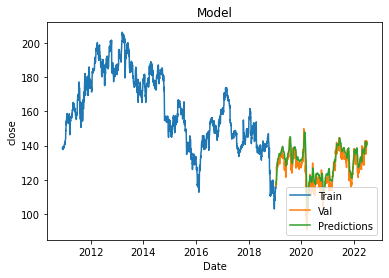

In [13]:
train = IBM_df[:training_data_len]

valid = IBM_df[training_data_len:]

valid['Predictions'] = predictions

plt.title('Model')

plt.xlabel('Date')

plt.ylabel('close')

plt.plot(train['close'])

plt.plot(valid[['close', 'Predictions']])

plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')

plt.show()

<AxesSubplot:xlabel='date'>

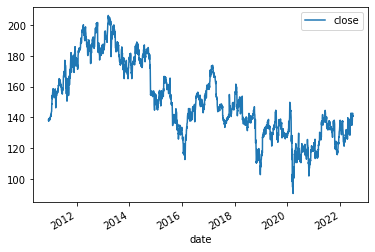

In [14]:
IBM_df.plot()

In [15]:
complete_IBM_df = pd.concat([train[['close']], valid[['close', 'Predictions']]])
complete_IBM_df

,close,Predictions
date,,
2010-12-06,138.613770,NaN
2010-12-07,137.686417,NaN
2010-12-08,138.604202,NaN
2010-12-09,137.954117,NaN
2010-12-10,138.451248,NaN
...,...,...
2022-06-27,142.800003,139.732712
2022-06-28,141.860001,140.352982
2022-06-29,140.710007,140.986084


In [16]:
IBM_df.to_csv("IBM_df.csv", index=False)

In [17]:
complete_IBM_df.to_csv("complete_IBM_df.csv", index=False)